In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nigeria-food-ai-dataset/1HZhs21IE2oNn_V7PF_atNDizdhV8z-vP


**Importing Dependences** and helper functions

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

#Importing my Beautiful functions for flexibility
!wget https://raw.githubusercontent.com/elinteerie/helper/main/helper_functions.py

from helper_functions import *

--2022-08-06 11:08:35--  https://raw.githubusercontent.com/elinteerie/helper/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14934 (15K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.58K  --.-KB/s    in 0.001s  

2022-08-06 11:08:35 (20.1 MB/s) - ‘helper_functions.py’ saved [14934/14934]



In [3]:
unzip_data('/kaggle/input/nigeria-food-ai-dataset/1HZhs21IE2oNn_V7PF_atNDizdhV8z-vP')

In [4]:
dir = '/nigfoodai'

In [5]:
walk_through_dir(dir)

In [6]:
train_dir = 'nigfoodai' # Will be splitted for test or Validation

In [7]:
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 labels ='inferred',
                                                                 label_mode="int",
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.15,
                                                                 subset='training',
                                                                 seed =42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                labels ='inferred',
                                                                 label_mode="int",
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.15,
                                                                 subset='validation',
                                                                seed =42)


Found 3449 files belonging to 14 classes.
Using 2932 files for training.


2022-08-06 11:08:51.997226: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 3449 files belonging to 14 classes.
Using 517 files for validation.


2022-08-06 11:08:52.413348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


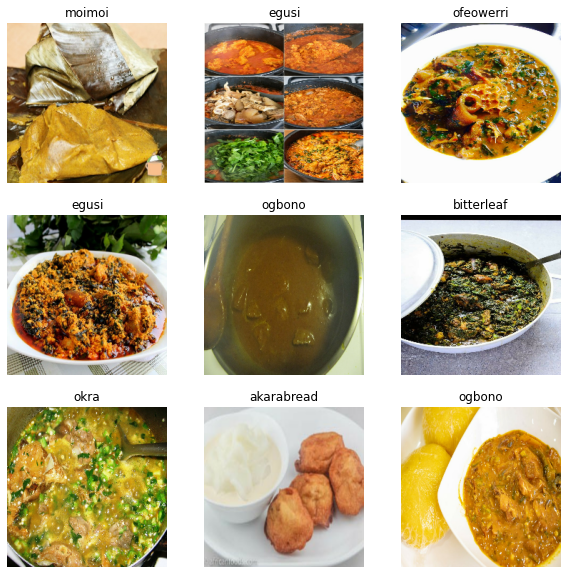

In [8]:
ngclass_names = train_data.class_names

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(ngclass_names[labels[i].numpy()])
    plt.axis("off")